In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.onnx
import torchvision

%matplotlib inline

plt.ion()   # interactive moden

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5 )
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda")

In [4]:
def get_dataset(data_dir, data_transforms ):


    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes

In [5]:
data_dir= "C:/Users/User/Rover-Trasher/"

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
# get train and test data
trainloader, testloader, classes, dataset_sizes=get_dataset(data_dir, data_transforms)
print('Classes: ',  classes)
print('The datasest have: ',  dataset_sizes ," images")

Classes:  ['nopaper', 'paper']
The datasest have:  {'train': 21, 'test': 4}  images


In [7]:
# Create new image show function for new transofration 
def imshow_resNet18(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

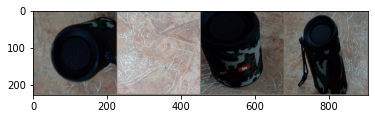

paper nopaper paper paper


In [8]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
#images, labels = dataiter.next()

# show images
imshow_resNet18(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
# Let's prepare the parameters for training the model
dataloaders = {'train': trainloader, 'test': testloader}
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
#Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


: 

: 